In [11]:
!pip install -U transformers scikit-learn numpy

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datasets import load_dataset

# load respective AIDev datasets
all_pull_request = load_dataset("hao-li/AIDev", "all_pull_request", split="train")
pr_task_type = load_dataset("hao-li/AIDev", "pr_task_type", split="train")
pr_commit_details = load_dataset("hao-li/AIDev", "pr_commit_details", split="train")
pull_request = load_dataset("hao-li/AIDev", "pull_request", split="train") # id
pr_comments = load_dataset("hao-li/AIDev", "pr_comments", split="train") # id, pr_id
pr_review_comments = load_dataset("hao-li/AIDev", "pr_review_comments", split="train") # pull_request_review_id, commit_id
pr_reviews = load_dataset("hao-li/AIDev", "pr_reviews", split="train") # pr_id, message
human_pull_request = load_dataset("hao-li/AIDev", "human_pull_request", split="train")
human_pr_task_type = load_dataset("hao-li/AIDev", "human_pr_task_type", split="train")

# convert from datasets to dataframes
all_pull_request_df = all_pull_request.to_pandas()
pr_task_type_df = pr_task_type.to_pandas()
pr_commit_details_df = pr_commit_details.to_pandas()
pull_request_df = pull_request.to_pandas()
pr_comments_df = pr_comments.to_pandas()
pr_review_comments_df = pr_review_comments.to_pandas()
pr_reviews_df = pr_reviews.to_pandas()
human_pull_request_df = human_pull_request.to_pandas()
human_pr_task_type_df = human_pr_task_type.to_pandas()

human_pull_request.parquet:   0%|          | 0.00/4.39M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6618 [00:00<?, ? examples/s]

human_pr_task_type.parquet:   0%|          | 0.00/716k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6618 [00:00<?, ? examples/s]

In [2]:
from collections import defaultdict

# merge
app_ptt = pr_task_type_df.merge(
    all_pull_request_df,
    left_on="id", right_on="id",
    how="inner"
)

#filter
rejected_pr_task_types = app_ptt[
    (app_ptt["state"] == "closed") &
    (app_ptt["merged_at"].isna())
]

app_ptt["merged_at"] = pd.to_datetime(app_ptt["merged_at"], errors="coerce")

accepted_pr_task_types = app_ptt[
    (app_ptt["state"] == "closed") &
    (app_ptt["merged_at"].notna())
]

all_task_type_count = app_ptt["type"].value_counts().to_dict()
rejected_task_type_count = rejected_pr_task_types["type"].value_counts().to_dict()
accepted_task_type_count = accepted_pr_task_types["type"].value_counts().to_dict()

rejection_rates = {}
accepted_rates = {}

for task_type, all_count in all_task_type_count.items():
    rejected_count = rejected_task_type_count.get(task_type, 0)
    accepted_count = accepted_task_type_count.get(task_type, 0)

    if all_count > 0:
        rejection_rates[task_type] = (rejected_count / all_count)*100
        accepted_rates[task_type] = (accepted_count / all_count)*100

print("Rejection Rates:")
print(dict(sorted(rejection_rates.items(), key=lambda item: item[1], reverse=True)))
print('')
print("Acceptance Rates:")
print(dict(sorted(accepted_rates.items(), key=lambda item: item[1], reverse=True)))

Rejection Rates:
{'other': 83.87096774193549, 'perf': 35.0, 'chore': 28.125, 'fix': 26.067110782136687, 'refactor': 23.33916083916084, 'feat': 21.56401384083045, 'style': 20.212765957446805, 'build': 18.819776714513555, 'revert': 18.75, 'test': 17.487266553480477, 'ci': 16.78832116788321, 'docs': 12.091587342423463}

Acceptance Rates:
{'docs': 84.04939542063288, 'ci': 79.07542579075427, 'test': 78.39558573853989, 'style': 77.6595744680851, 'revert': 75.0, 'build': 74.8006379585327, 'feat': 71.07266435986159, 'refactor': 70.1048951048951, 'chore': 68.75, 'fix': 64.9765605724155, 'perf': 55.294117647058826, 'other': 9.67741935483871}


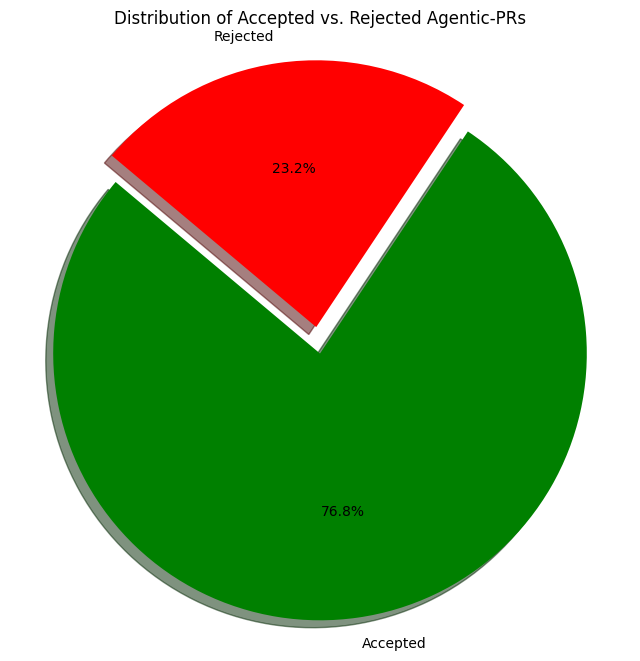

In [3]:
import matplotlib.pyplot as plt

# Sum the total number of accepted and rejected PRs
total_accepted = sum(accepted_task_type_count.values())
total_rejected = sum(rejected_task_type_count.values())

# Data for the pie chart
labels = ['Accepted', 'Rejected']
sizes = [total_accepted, total_rejected]
colors = ['green', 'red']
explode = (0.1, 0) # explode the 1st slice (Accepted)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Distribution of Accepted vs. Rejected Agentic-PRs')
plt.axis('equal')
plt.show()

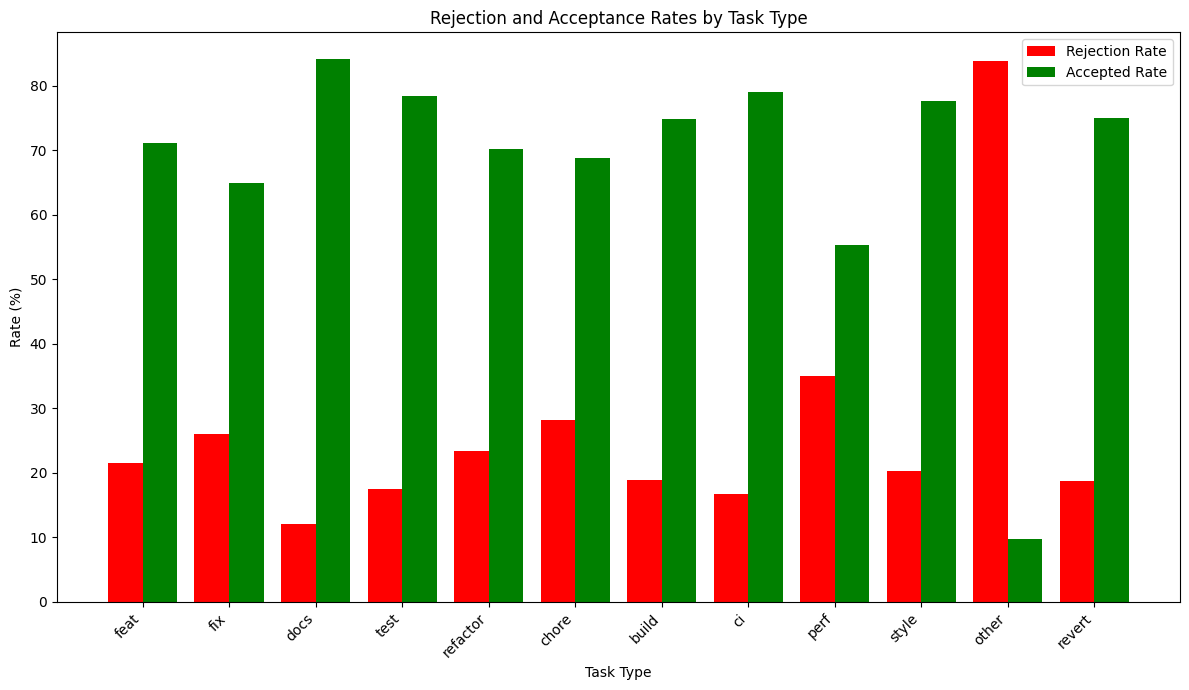

In [4]:
tasks = list(rejection_rates.keys())
rejection_values = list(rejection_rates.values())
accepted_values = list(accepted_rates.values())

width = 0.4
x = np.arange(len(tasks))

plt.figure(figsize=(12, 7))

plt.bar(x, rejection_values, width, label='Rejection Rate', color='red')
plt.bar(x + width, accepted_values, width, label='Accepted Rate', color='green')

plt.title('Rejection and Acceptance Rates by Task Type')
plt.ylabel('Rate (%)')
plt.xlabel('Task Type')
plt.xticks(x + width / 2, tasks, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

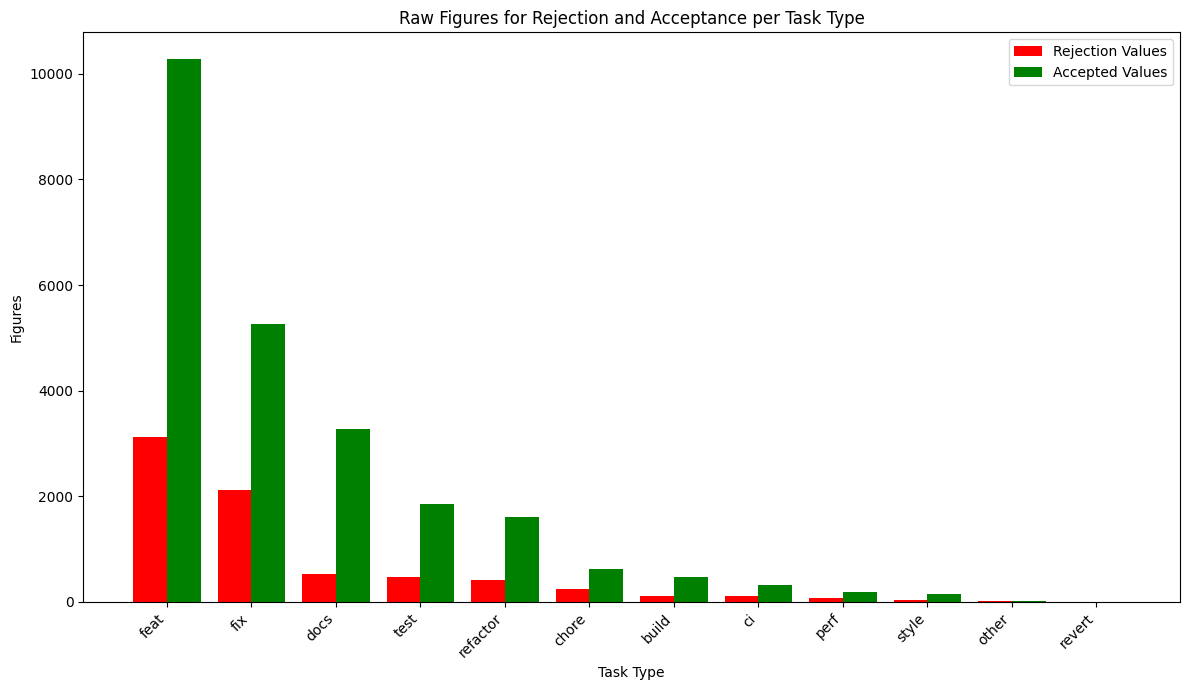

In [5]:
# all_task_type_count = app_ptt["type"].value_counts().to_dict()
# closed_task_type_count = closed_pr_task_types["type"].value_counts().to_dict()
# accepted_task_type_count = accepted_pr_task_types["type"].value_counts().to_dict()

rejection_values = list(rejected_task_type_count.values())
accepted_values = list(accepted_task_type_count.values())

x = np.arange(len(tasks))

plt.figure(figsize=(12, 7))

plt.bar(x, rejection_values, width, label='Rejection Values', color='red')
plt.bar(x + width, accepted_values, width, label='Accepted Values', color='green')

plt.title('Raw Figures for Rejection and Acceptance per Task Type')
plt.ylabel('Figures')
plt.xlabel('Task Type')
plt.xticks(x + width / 2, tasks, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Merge rejected PRs with their review messages and comments
# This creates a combined dataset of all review messages and comments for rejected PRs

rejected_pr_df = all_pull_request_df[
    (all_pull_request_df["state"] == "closed") &
    (all_pull_request_df["merged_at"].isna())
]

print(rejected_pr_df.head())

# merge with pr_reviews to get the review messages
rejected_pr_reviews_df = pd.merge(
    rejected_pr_df,
    pr_reviews_df,
    left_on='id',
    right_on='pr_id',
    how='inner'
)

# maybe merge with pr_review_comments too?

# merge with pr_comments to get the comment bodies
rejected_pr_comments_df = pd.merge(
    rejected_pr_df,
    pr_comments_df,
    left_on='id',
    right_on='pr_id',
    how='inner'
)

print("Columns of rejected_pr_reviews_df:", rejected_pr_reviews_df.columns)
print("Columns of rejected_pr_comments_df:", rejected_pr_comments_df.columns)

            id  number                                              title  \
2   3264042289    1600  Add Evals frontend implementation plan and HTM...   
3   3264042318    1601  Add 4 new BfDs components for Evals interface ...   
7   3264428170     464          🚀 Complete 64-Agent System Implementation   
24  3264796443    1609  Move codebot workspace storage to ./tmp/codebo...   
26  3264933329    2911  Fix: Wait for all partitions in load_collectio...   

          user    user_id   state            created_at             closed_at  \
2    justicart    6766889  closed  2025-07-25T18:26:15Z  2025-07-25T23:19:14Z   
3    justicart    6766889  closed  2025-07-25T18:26:16Z  2025-07-25T23:19:11Z   
7       ruvnet    2934394  closed  2025-07-25T21:26:37Z  2025-07-25T21:29:18Z   
24    randallb     448694  closed  2025-07-26T01:07:32Z  2025-07-26T21:47:32Z   
26  weiliu1031  108661493  closed  2025-07-26T02:59:01Z  2025-07-29T07:01:20Z   

   merged_at                                      

In [7]:
import re

def clean_text(text):
    if text is None:
        return ""
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', str(text))
    # You can add more cleaning steps here
    return text

rejected_human_pr_df = human_pull_request_df[
    (human_pull_request_df['state'] == 'closed') &
    (human_pull_request_df['merged_at'].isna())
].copy()

# merge with pr_reviews to get review messages
rejected_human_reviews_df = pd.merge(
    rejected_human_pr_df,
    pr_reviews_df,
    left_on='id',
    right_on='pr_id',
    how='inner'
)

# merge with pr_comments to get comment bodies
rejected_human_comments_df = pd.merge(
    rejected_human_pr_df,
    pr_comments_df,
    left_on='id',
    right_on='pr_id',
    how='inner'
)

# Combine all relevant human text into a single list and clean it
# Note: 'message' is from pr_reviews_df and 'body_y' is from pr_comments_df after the merge
all_rejected_human_text = (
    rejected_human_reviews_df['body_x'].dropna().apply(clean_text).tolist() +
    rejected_human_comments_df['body_y'].dropna().apply(clean_text).tolist()
)

print(f"Number of rejected human comments/reviews retrieved: {len(all_rejected_human_text)}")


# combine all relevant AI PR text into a single list and clean the text
all_rejected_agent_text = (
    rejected_pr_reviews_df['body_x'].dropna().apply(clean_text).tolist() +
    rejected_pr_comments_df['body_y'].dropna().apply(clean_text).tolist()
)

# combine list into a single long string
combined_text = ' '.join(all_rejected_agent_text).lower()

In [27]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
import scipy.sparse

# Add the missing `.A` attribute dynamically
scipy.sparse.spmatrix.A = property(lambda self: self.toarray())

representation_model = KeyBERTInspired()
seed_topic_list = [
    ["test", "testing", "unit", "integration", "assert", "mock", "fix", "failing"], # Testing issues
    ["security", "vulnerability", "vulnerabilities", "bug", "exploit", "unauthenticated"], # Security concerns
    ["error", "fix", "bug", "crash", "incorrect", "problem"], # Bug and error fixes
    ["style", "linter", "format", "PEP8", "prettier", "indentation"] # Style issues
]

topic_model = BERTopic(language='english',
                       representation_model=representation_model,
                       calculate_probabilities=True,
                       seed_topic_list=seed_topic_list,)

topics, probs = topic_model.fit_transform(all_rejected_agent_text)

# 1. Get the Topic Info table
# This table provides a summary of each topic: Topic ID, count, and key terms
topic_info = topic_model.get_topic_info()

# the top 10 most frequent topics including the outlier topic (-1)
top_n_topics = topic_info.head(11)

print("Most Frequent Topics:")
print(top_n_topics)

print("\nKeywords for Topic 0 (The most frequent non-outlier topic):")
print(topic_model.get_topic(0))

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/hdbscan/prediction.py:663: RuntimeWarning: invalid value encountered in scalar divide
  in_cluster_probs = all_points_prob_in_some_cluster(


Most Frequent Topics:
    Topic  Count                                               Name  \
0      -1   8251                    -1_updated_changes_update_build   
1       0    955  0_deploymentsummary_deploymentssummary_updated...   
2       1    639          1_repository_ignore_automatically_disable   
3       2    543          2_repository_ignore_automatically_disable   
4       3    221                          3_more_to_than_inactivity   
5       4    216                      4_fix_options_failures_ignore   
6       5    181                          5_more_due_inactivity_for   
7       6    177                                         6_due_to__   
8       7    170                              7_ci_monitoring_pr_ai   
9       8    168                             8_repository_ci_add_on   
10      9    160                    9_packages_maintainer_pr_commit   

                                       Representation  \
0   [updated, changes, update, build, issues, docu...   
1   [deploy

In [1]:
topics_human, probs_human = topic_model.fit_transform(all_rejected_human_text)

# Get the topic information for the human PRs
topic_info_human = topic_model.get_topic_info()
print("Human PR Topic Info:")
print(topic_info_human)

human_topic_representations = topic_model.topic_representations_
print("\nHuman PR Topic Representations:")
print(human_topic_representations)

NameError: name 'topic_model' is not defined

In [9]:
from transformers import AutoTokenizer
from collections import Counter

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized_comments = [tokenizer.tokenize(text) for text in all_rejected_text]

# To perform a simple keyword count on whole words:
all_tokens = [token for comment in tokenized_comments for token in comment]

word_tokens = [token.lower() for token in all_tokens if token.isalpha()]

most_common_words = Counter(word_tokens).most_common(50)
print("Most Common Words:")
print(most_common_words)

keywords = ['bug', 'incorrect', 'test', 'style', 'security','inefficient', 'error', 'security', 'vulnerability']
keyword_counts = {keyword: 0 for keyword in keywords}

for token in word_tokens:
    if token in keyword_counts: keyword_counts[token] += 1
print("\nSpecific Keyword Counts:")
print(dict(sorted(keyword_counts.items(), key=lambda item: item[1], reverse=True)))

Token indices sequence length is longer than the specified maximum sequence length for this model (1283 > 512). Running this sequence through the model will result in indexing errors


Most Common Words:
[('the', 77435), ('to', 67634), ('p', 42820), ('and', 39948), ('a', 39616), ('j', 34919), ('code', 34055), ('in', 31771), ('for', 30216), ('this', 28007), ('build', 27197), ('with', 20296), ('pr', 18582), ('test', 17284), ('summary', 15870), ('on', 15859), ('of', 15446), ('is', 14883), ('di', 14430), ('index', 13043), ('details', 13003), ('by', 12871), ('i', 12827), ('you', 12671), ('d', 12612), ('from', 12541), ('assets', 12474), ('package', 12049), ('add', 11901), ('review', 11285), ('tests', 11209), ('stream', 11086), ('td', 10884), ('map', 10643), ('as', 10572), ('changes', 10395), ('all', 10110), ('it', 10094), ('run', 9642), ('li', 9516), ('hr', 9379), ('comment', 9181), ('can', 9086), ('comments', 9055), ('new', 8831), ('work', 8795), ('s', 8584), ('con', 8573), ('file', 8542), ('fix', 8292)]

Specific Keyword Counts:
{'test': 17284, 'error': 7033, 'security': 1280, 'style': 648, 'bug': 597, 'incorrect': 255, 'vulnerability': 169, 'inefficient': 0}


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# aggregate quantitative features from pr_commit_details_df - this creates a summary for each PR
pr_commit_agg = pr_commit_details_df.groupby('pr_id').agg(
    total_additions=('additions', 'sum'),
    total_deletions=('deletions', 'sum'),
    num_files_changed=('filename', 'count')
).reset_index()

# merge with the main PR dataframe
pr_features_df = pd.merge(
    all_pull_request_df,
    pr_commit_agg,
    left_on='id',
    right_on='pr_id',
    how='left'
)

# fill the quantitative columns with 0
pr_features_df[['total_additions', 'total_deletions', 'num_files_changed']] = pr_features_df[['total_additions', 'total_deletions', 'num_files_changed']].fillna(0)

# fill missing descriptions with an empty string separately
pr_features_df['body'] = pr_features_df['body'].fillna('')

# create the target variable
pr_features_df['is_rejected'] = np.where(
    (pr_features_df['state'] == 'closed') & (pr_features_df['merged_at'].isna()), 1, 0
)

# extract NLP features using TF-IDF on the PR description body
tfidf_vectorizer = TfidfVectorizer(max_features=250, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(pr_features_df['body'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# combine all features into a final DataFrame
X = pd.concat([pr_features_df[['total_additions', 'total_deletions', 'num_files_changed']], tfidf_df], axis=1)
y = pr_features_df['is_rejected']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set size: {X_train.shape[0]} PRs")
print(f"Testing set size: {X_test.shape[0]} PRs")

# Initialize a classification model
model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the unseen test data
y_pred = model.predict(X_test)

# Print a comprehensive classification report
print("\nModel Performance Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix to see where the model made mistakes
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Training set size: 746232 PRs
Testing set size: 186559 PRs

Model Performance Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96    172601
           1       0.28      0.00      0.00     13958

    accuracy                           0.92    186559
   macro avg       0.60      0.50      0.48    186559
weighted avg       0.88      0.92      0.89    186559


Confusion Matrix:
[[172522     79]
 [ 13928     30]]



Calculated Rejection Rates:
agent
Claude_Code     0.153592
Copilot         0.206553
Cursor          0.080477
Devin           0.299086
Human           0.161378
OpenAI_Codex    0.057742
Name: is_rejected, dtype: float64

------------------------------
Comparison of PR Metrics (Agent vs. Human):
              rejection_rate  avg_additions  avg_deletions  avg_files_changed
agent                                                                        
Claude_Code         0.153592     568.010707     202.926416           4.531439
Copilot             0.206553       0.000000       0.000000           0.000000
Cursor              0.080477      86.809174      46.972527           1.148447
Devin               0.299086     275.451923     159.147088           5.693047
Human               0.161378       0.000000       0.000000           0.000000
OpenAI_Codex        0.057742      14.937783       6.490432           0.360965


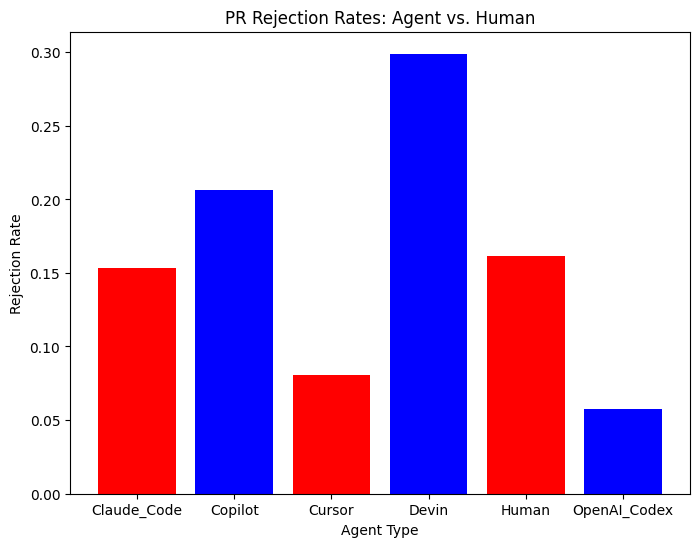

In [26]:
# single DataFrame for all Human and Agent PRs
agent_and_human_df = pd.concat([all_pull_request_df, human_pull_request_df], ignore_index=True)

# merge
agent_and_human_df = pd.merge(
    agent_and_human_df,
    all_commit_agg,
    left_on='id',
    right_on='pr_id',
    how='left'
)

agent_and_human_df[['total_additions', 'total_deletions', 'num_files_changed']] = agent_and_human_df[['total_additions', 'total_deletions', 'num_files_changed']].fillna(0)

agent_and_human_df['is_rejected'] = np.where(
    (agent_and_human_df['state'] == 'closed') & (agent_and_human_df['merged_at'].isna()), 1, 0
)

rejection_rates_for_agent_and_human_prs = agent_and_human_df.groupby('agent')['is_rejected'].mean()
print("\nCalculated Rejection Rates:")
print(rejection_rates_for_agent_and_human_prs)

comparison_df = agent_and_human_df.groupby('agent').agg(
    rejection_rate=('is_rejected', 'mean'),
    avg_additions=('total_additions', 'mean'),
    avg_deletions=('total_deletions', 'mean'),
    avg_files_changed=('num_files_changed', 'mean')
)

print('\n------------------------------')
print("Comparison of PR Metrics (Agent vs. Human):")
print(comparison_df)

plt.figure(figsize=(8, 6))
# Get a list of the agent types to use for the plot colors
agent_types = comparison_df.index.tolist()
plt.bar(agent_types, comparison_df['rejection_rate'], color=['red', 'blue', 'green', 'yellow', 'indigo', 'violet', 'grey'])
plt.title('PR Rejection Rates: Agent vs. Human')
plt.ylabel('Rejection Rate')
plt.xlabel('Agent Type')
plt.xticks(rotation=0)
plt.show()

In [ ]:
from bertopic.representation import KeyBERTInspired
from sklearn.cluster import MiniBatchKMeans

# --- Assumed DataFrames ---
# human_pull_request_df: Contains human PR data
# pr_comments_df: Contains raw comments for all PRs
# pr_reviews_df: Contains raw review messages for all PRs

# 1. Filter for rejected human PRs
rejected_human_pr_df = human_pull_request_df[
    (human_pull_request_df['state'] == 'closed') &
    (human_pull_request_df['merged_at'].isna())
]

# 2. Merge with comments and reviews to get all text
rejected_human_comments_df = pd.merge(
    rejected_human_pr_df, pr_comments_df, left_on='id', right_on='pr_id', how='inner'
)
rejected_human_reviews_df = pd.merge(
    rejected_human_pr_df, pr_reviews_df, left_on='id', right_on='pr_id', how='inner'
)

# 3. Combine all relevant text
all_rejected_human_text = (
    rejected_human_reviews_df['message'].dropna().tolist() +
    rejected_human_comments_df['body'].dropna().tolist()
)

# 4. Configure and train the BERTopic model
# Use the same seed topics for a fair comparison
seed_topic_list = [
    ["test", "testing", "unit", "integration", "assert", "mock", "fix", "failing"],
    ["security", "vulnerability", "vulnerabilities", "bug", "exploit", "unauthenticated"],
    ["error", "fix", "bug", "crash", "incorrect", "problem"],
    ["style", "linter", "format", "PEP8", "prettier", "indentation"]
]
cluster_model = MiniBatchKMeans(n_clusters=len(seed_topic_list) + 1, random_state=42, n_init=10)

topic_model_human = BERTopic(
    representation_model=KeyBERTInspired(),
    language='english',
    seed_topic_list=seed_topic_list,
    hdbscan_model=cluster_model
)

topics_human, probs_human = topic_model_human.fit_transform(all_rejected_human_text)

# 5. Analyze the results
topic_info_human = topic_model_human.get_topic_info()
print("BERTopic Analysis for Rejected Human PRs:")
print(topic_info_human)